In [1]:
import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from scipy.ndimage import gaussian_filter
from numba import njit
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
from scipy.spatial import KDTree
# from numba_kdtree import KDTree

basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

import sys
sys.path.append(basepath+'note/')
import galaxy

import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

# import vortrace as vt
import Cvortrace
from vortrace.vortrace import ProjectionCloud

In [2]:
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r"""
\usepackage{amsmath}
""")
# mpl.rcParams.update({'font.size': 22})
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
# color palette
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

columnwidth = 242.26653 / 72.27 # converts pts to inches
textwidth = 513.11743 / 72.27
textheight = 657.3189 / 72.27

mpl.rcParams.update({'font.size': 8})

In [3]:
def load_galaxy(sim, idx=320):
    Rs, Vv, ecc = sim
    key = 'lvl4-Rs'+Rs+'-Vv'+Vv+'-e'+ecc
    return galaxy.Galaxy(basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output',
                                              idx, orient=True)

In [5]:
Rs_list = ['116', '129', '142']
Vv_list = ['116', '129', '142']
eta_list = ['04', '05', '06']

sims = []
for Rs in Rs_list:
    for Vv in Vv_list:
        for eta in eta_list:
            sims.append((Rs, Vv, eta))

gals = []
for sim in tqdm(sims):
    gals.append(load_galaxy(sim))

100%|██████████| 27/27 [01:03<00:00,  2.37s/it]


In [6]:
def gadget_spline(u, h=1, M=1):
    pre = M * 8 / (np.pi * h**3)
    ans = np.zeros_like(u)
    ans0 = 1 - 6*u**2 + 6 * u**3
    ans1 = 2 * (1-u)**3
    
    key0 = u <= 0.5
    key1 = np.logical_and(u > 0.5, u <= 1)
    ans[key0] = ans0[key0]
    ans[key1] = ans1[key1]
    
    ans *= pre
    
    return ans

def get_sigma_interp():
    blist = np.linspace(0, 1, 1000)
    slist = np.linspace(-1, 1, 1000)
    bgrid, sgrid = np.meshgrid(blist, slist, indexing='ij')
    
    rgrid = np.sqrt(bgrid**2 + sgrid**2)
    Wgrid = gadget_spline(rgrid, 1)
    
    sigma = np.trapz(Wgrid, slist, axis=1)
    return blist, sigma

# @njit
def sum_kernel_surface_dens(xpts, ypts, x, y, M, h, bint, sigmaint):
    
    pos = np.transpose([x, y])
    sigma = np.zeros(len(xpts)*len(ypts))
    
    xgrid, ygrid = np.meshgrid(xpts, ypts, indexing='ij')
    grid = np.transpose([xgrid.ravel(), ygrid.ravel()])
    
    tree_grid = KDTree(grid)

    # now do a ball query
    ball_idx = tree_grid.query_ball_point(pos, h)
    
    ball_idx_filter = [b for b in ball_idx if b]
    
    part_idx = np.concatenate([[i] * len(b) for i,b in enumerate(ball_idx) if b])
    ball_idx = np.concatenate(ball_idx_filter)
    
    # now get impact parameter
    b = np.linalg.norm(pos[part_idx] - grid[ball_idx], axis=1)
    sigma_ = M[part_idx]/h[part_idx]**3 * np.interp(b/h[part_idx], bint, sigmaint)
    sigma = np.bincount(ball_idx, weights=sigma_, minlength=len(xpts)*len(ypts))

    sigma = np.reshape(sigma, (len(xpts), len(ypts)))

    return sigma

In [7]:
def plot_star_panel(fig, ax, gal, ix, iy, cmap=None):
    L = 30
    Nres = 128
    vmin = 1e-5
    vmax = 1
    sigma = 0.5

    sn, sub = gal.sn, gal.sub
    is_star = sn.part4.GFM_StellarFormationTime > 0
    pos = sn.part4.rotpos[is_star]
    mass = sn.part4.mass.value[is_star]
    
    # get softening lengths as dist to 32nd nearest neighbor
    tree = KDTree(pos)
    h, _ = tree.query(pos, 33)
    h = h[:,-1]
    
    dL = L/Nres
    xpts = np.arange(-L/2, L/2, dL) + dL/2.
    ypts = np.arange(-L/2, L/2, dL) + dL/2.
    
    x = pos[:,ix]
    y = pos[:,iy]

    bint, sigmaint = get_sigma_interp()
    H = sum_kernel_surface_dens(xpts, ypts, x, y, mass, h, bint, sigmaint)
    
    # H, _, _, _ = binned_statistic_2d(x, y, mass/dx/dy, statistic='sum', bins=[xbins, ybins])
    # H = gaussian_filter(H, sigma=sigma)
    
    if vmin is not None:
        H = np.clip(H, vmin, vmax)
    
    extent = [-L/2, L/2, -L/2, L/2]
    im = ax.imshow(H.T, origin='lower', extent=extent, 
                       norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), cmap=cmap)
    
    return im

100%|██████████| 27/27 [02:25<00:00,  5.38s/it]


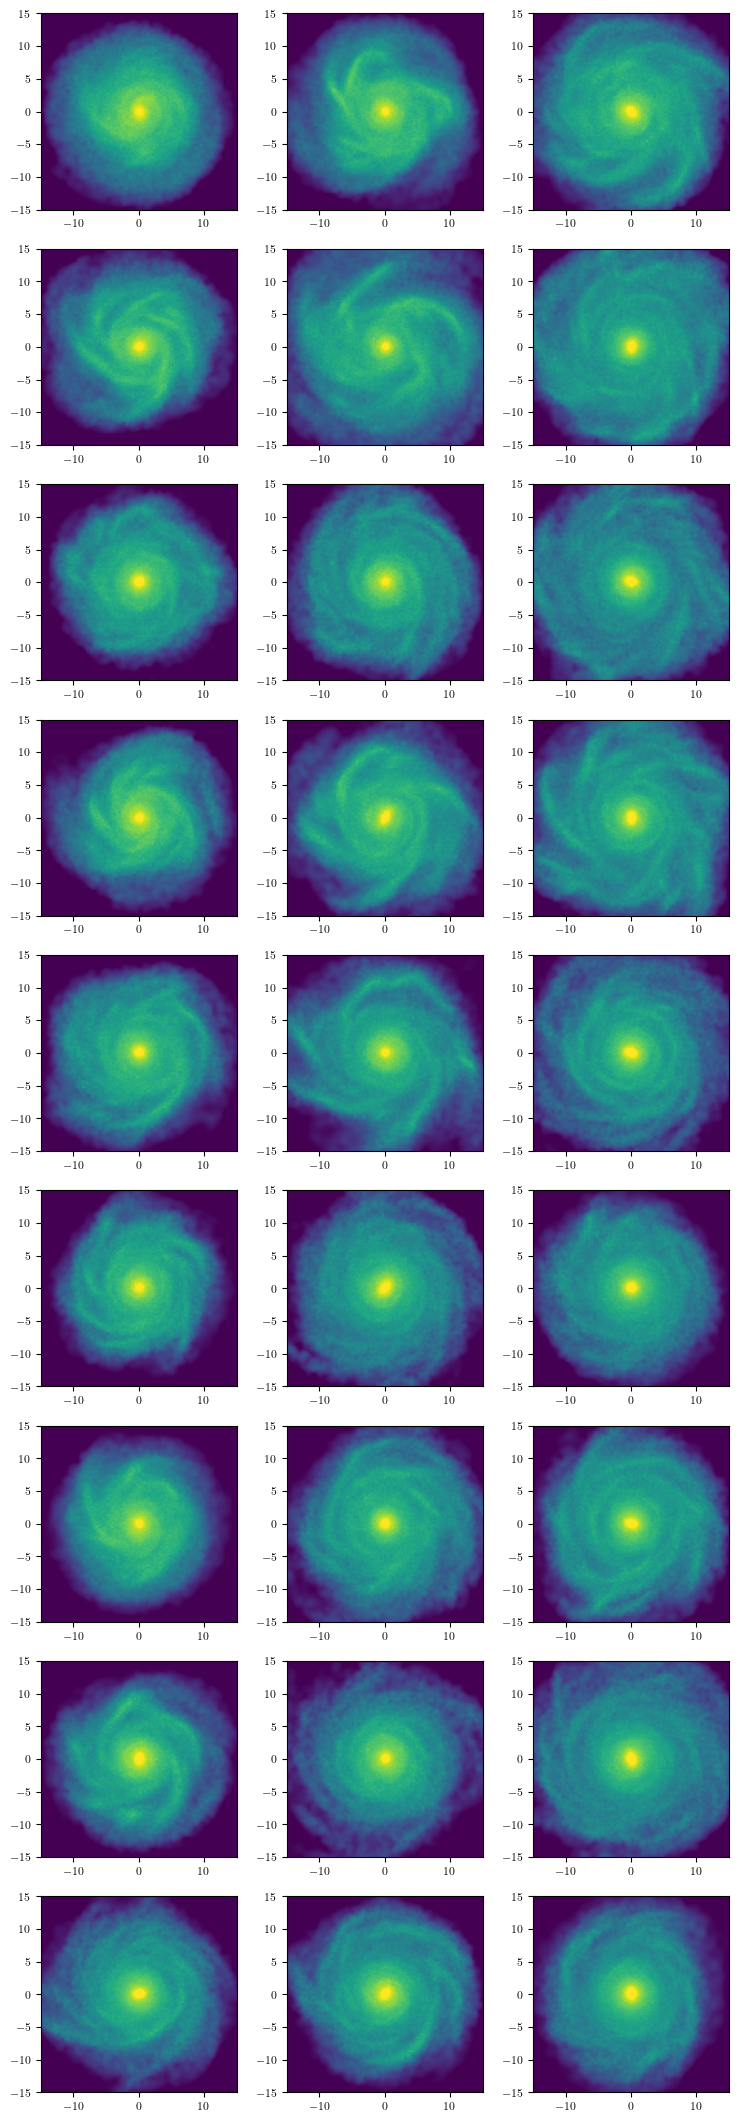

In [10]:
fig, axs = plt.subplots(9, 3, figsize=(9, 27))

for gal,ax in zip(tqdm(gals), axs.ravel()):
    plot_star_panel(fig, ax, gal, 0, 1)